In [2]:
#Import libraries
import numpy as np
import lasagne
import theano
import theano.tensor as T
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import fnmatch
from Unet import *
import cPickle
from time import sleep
from generators import batch_generator, threaded_generator, random_crop_generator, center_crop_generator
from sklearn.metrics import roc_auc_score
from LMDBLoader import read_lmdb_images, read_lmdb_labels, read_lmdb
from keras.utils import np_utils
import os.path
import nibabel as nib
import scipy
from scipy.stats import threshold
from data_preparation import *
import itertools
import wget
from itertools import islice
from scipy.misc import imresize, imrotate

#os.environ["CUDA_VISIBLE_DEVICES"]="1"

np.random.seed(123)
%matplotlib inline


Couldn't import dot_parser, loading of dot files will not be possible.


WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

ERROR (theano.sandbox.cuda): ERROR: Not using GPU. Initialisation of device 3 failed:
Bad device number 3. Only 1 devices available.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5105)
Using TensorFlow backend.


for details.

--2017-03-17 20:16:18--  https://www.dropbox.com/s/2vjan6mbcf2fsit/target.npy?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 108.160.172.206
Connecting to www.dropbox.com (www.dropbox.com)|108.160.172.206|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/content_link/kP1mcNutPSI7QJwlxp3ltBHPBnWBGQcs8KHVEXg93Owb8qUaFJhwB9sU3s6JUJNO/file [following]
--2017-03-17 20:16:23--  https://dl.dropboxusercontent.com/content_link/kP1mcNutPSI7QJwlxp3ltBHPBnWBGQcs8KHVEXg93Owb8qUaFJhwB9sU3s6JUJNO/file
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 45.58.75.165
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|45.58.75.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 461373536 (440M) [text/plain]
Saving to: ‘target.npy’

100%[======================================>] 461,373,536 15.9MB/s   in 34s    

2017-03-17 20:16:59 (12.8 MB/s) - ‘target.npy’ saved [4

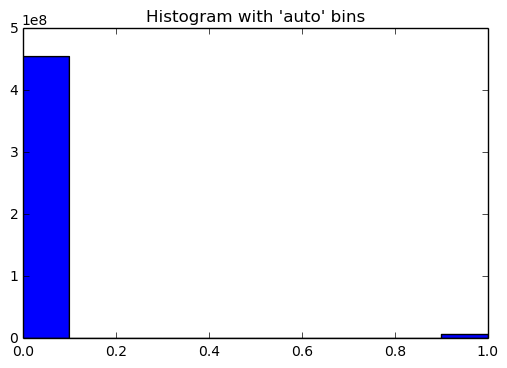

In [6]:
#Training/Evaluation parameters. You can change these parameters
BATCH_SIZE = 1
N_EPOCHS = 10
N_BATCHES_PER_EPOCH = 100
PATCH_SIZE = 128
 


if os.path.exists("names.npy") == False:
    !wget -N https://www.dropbox.com/s/h4no2pm970im82k/data.npy?dl=0 -O data.npy
    !wget -N https://www.dropbox.com/s/2vjan6mbcf2fsit/target.npy?dl=0 -O target.npy
    !wget -N https://www.dropbox.com/s/0wljupgym34uwuu/names.npy?dl=0 -O names.npy
        
names = np.load("names.npy")
data_train = np.load("data.npy").astype('float32')
target_train = np.load("target.npy").astype('uint8')


target_train[target_train>0]=1

print "Data shape ", data_train.shape
print "Target shape ", target_train.shape
print "Names length ", len(names)


print "Target max intensity ", np.max(target_train)

mean = np.mean(data_train)  # mean for data centering
std = np.std(data_train)  # std for data normalization

data_train -= mean
data_train /= std

total_foreground4 = 0
total_foreground3 = 0
total_foreground2 = 0
total_foreground1 = 0
total_background = 0

total_foreground4 += np.sum(target_train == 4)
total_foreground3 += np.sum(target_train == 3)
total_foreground2 += np.sum(target_train == 2)
total_foreground1 += np.sum(target_train == 1)
total_background += np.sum(target_train == 0)


print "total_background= ", total_background, " total_foreground1 ", total_foreground1, " total_foreground2 ", total_foreground2

plt.hist(target_train.ravel())  
plt.title("Histogram with 'auto' bins")
plt.show()

names_valid = names[201:220]
data_valid = data_train[201:220]
target_valid = target_train[201:220]
data_test = data_valid
target_test = target_valid
data_train = data_train[0:200]
target_train = target_train[0:200]



data_train.shape  (200, 1, 128, 128, 128)
data_valid.shape  (200, 1, 128, 128, 128)
Name shape   (19,)
Name:   VSD.Brain.XX.O.MR_Flair.35804.mha


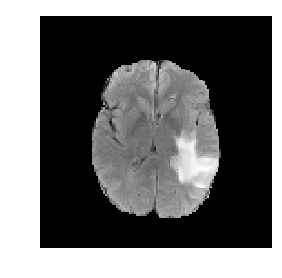

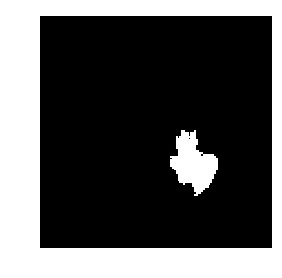

total_background=  2069732  total_foreground  27420.0
(200, 1, 128, 128, 128)


In [7]:
#Display the original image and segmentation image for sanity check
print "data_train.shape ", data_train.shape
print "data_valid.shape ", target_train.shape
print "Name shape  ", names_valid.shape

print "Name:  ", names_valid[12]

plt.figure(figsize=(3,3))
plt.imshow(data_valid[12][0][50], cmap = cm.Greys_r, interpolation='none')
plt.axis('off')
plt.show()

plt.figure(figsize=(3,3))
plt.imshow(target_test[12][0][50], cmap = cm.Greys_r, interpolation='none')
plt.axis('off')
plt.show()

total_foreground=0
total_background=0
total_foreground += np.sum(target_test[12])
total_background += np.sum(target_test[12] == 0)
print "total_background= ", total_background, " total_foreground ", total_foreground

print target_train.shape

In [4]:
 
#Build network by passing specific parameters. See UNet.py for architecture
net = build_UNet(n_input_channels=1, BATCH_SIZE=BATCH_SIZE, num_output_classes=2, pad='same',
                     nonlinearity=lasagne.nonlinearities.elu, input_dim=(PATCH_SIZE, PATCH_SIZE),depth=128,
                     base_n_filters=24,kernel_size=3, do_dropout=True)

#Point network's output layer to output_layer_for_loss parameter parameter for later use
output_layer_for_loss = net["output_flattened"]


#Some sanity check to see shape information for specific layers' outputs
print "Net output shape", net['output_segmentation'].output_shape
print "output_layer_for_loss", output_layer_for_loss.output_shape



net['reshapeSeg']  (2, 2097152)
Net output shape (1, 2, 128, 128, 128)
output_layer_for_loss (2097152, 2)


In [5]:

#Class distribution between the two classes
class_frequencies = np.array([np.sum(target_train == 0) ,
                              np.sum(target_train == 1)  ])

# We are taking the log here because we want the net to focus more on the foreground pixels but not too much (otherwise
# it would not be penalized enough for missclassifying terrain pixels which results in too many false positives)
class_weights = np.log(class_frequencies[[1,0]])
class_weights = class_weights / np.sum(class_weights) * 2.
class_weights = class_weights.astype(np.float32)


#Tensors
x_sym = T.TensorType('float32',(False,)*5) ('inputs') #Input tensor (i.e. images)
seg_sym = T.ivector() #Target tensor (i.e. segmented images)
w_sym = T.vector() #Weight tensor for initializtion (i.e. see class_weights above)

#Add some weight decay for more regulization to the loss function
l2_loss = lasagne.regularization.regularize_network_params(output_layer_for_loss, lasagne.regularization.l2) * 1e-4
#This is prediction function
prediction_train = lasagne.layers.get_output(output_layer_for_loss, x_sym, deterministic=False)
# This is the main loss function. We could use a binary loss but I stuck with categorical crossentropy so that less code has to be changed if your
# application has more than two classes
loss = lasagne.objectives.categorical_crossentropy(prediction_train, seg_sym)
# We multiply our loss by a weight map. In this example the weight map only increases the loss for foreground pixels and
# decreases the loss for other pixels. We do this to ensure that the network puts more focus on getting the foreground right
loss *= w_sym
loss = loss.mean()
loss += l2_loss

#This is the accuracy function
acc_train = T.mean(T.eq(T.argmax(prediction_train, axis=1), seg_sym), dtype=theano.config.floatX)


#Repeat the same code for the testing phase. This phase is deterministic. The parameters (i.e. weights, biases) do not update during test phase

#This is prediction function
prediction_test = lasagne.layers.get_output(output_layer_for_loss, x_sym, deterministic=True)
# This is the main loss function. We could use a binary loss but I stuck with categorical crossentropy so that less code has to be changed if your
# application has more than two classes
loss_val = lasagne.objectives.categorical_crossentropy(prediction_test, seg_sym)
# We multiply our loss by a weight map. In this example the weight map only increases the loss for foreground pixels and
# decreases the loss for other pixels. We do this to ensure that the network puts more focus on getting the foreground right
loss_val *= w_sym
loss_val = loss_val.mean()
loss_val += l2_loss

#This is the accuracy function
acc = T.mean(T.eq(T.argmax(prediction_test, axis=1), seg_sym), dtype=theano.config.floatX)

#Use params to point to the network parameters
params = lasagne.layers.get_all_params(output_layer_for_loss, trainable=True)

#Learning rate has to be a shared variable because we decrease it with every epoch
learning_rate = theano.shared(np.float32(0.001))

#Use adam optimizer to update the parameters based on loss and learning rate
updates = lasagne.updates.adam(loss, params, learning_rate=learning_rate)

#Create a convenience function get_segmentation to get the segmentation
seg_output = lasagne.layers.get_output(net["output_segmentation"], x_sym, deterministic=True)
get_segmentation = theano.function([x_sym], seg_output)



#This is the training function. It takes 3 inputs: x_sym, seg_sym, w_sym and it outputs loss, acc_train and it calls updates to update the network
train_fn = theano.function([x_sym, seg_sym, w_sym], [loss, acc_train], updates=updates, allow_input_downcast=True)

#This is the testing/validation function. It takes 3 inputs: x_sym, seg_sym, w_sym and it outputs loss_val, acc
val_fn = theano.function([x_sym, seg_sym, w_sym], [loss_val, acc],  allow_input_downcast=True)

#We need this for calculating the AUC score
get_class_probas = theano.function([x_sym], prediction_test)




In [6]:


print "Started experiment"

for epoch in range(N_EPOCHS):
    train_generator = batch_generator(data_train, target_train, BATCH_SIZE, shuffle=True)

    #Training phase
    losses_train = []
    n_batches = 0
    accuracies_train = []
    for data, target in train_generator:
        target_flat = target.ravel()
        loss, acc = train_fn(data.astype(np.float32), target_flat,class_weights[target_flat])
        losses_train.append(loss)
        accuracies_train.append(acc)
        n_batches += 1
        if n_batches > N_BATCHES_PER_EPOCH:
            break
    print "epoch: ", epoch, "\ntrain accuracy: ", np.mean(accuracies_train), " train loss: ", np.mean(losses_train)

    losses_val = []
    accuracies_val = []
    auc_val = []
    dice = []
    #Testing phase
    validation_generator = batch_generator(data_valid, target_valid, BATCH_SIZE, shuffle=False)
    for data, target in validation_generator:
        target_flat = target.ravel()
        loss, acc = val_fn(data.astype(np.float32), target_flat, class_weights[target_flat])
        losses_val.append(loss)
        accuracies_val.append(acc)
        auc_val.append(roc_auc_score(target_flat, get_class_probas(data)[:, 1]))
    print "val accuracy: ", np.mean(accuracies_val), " val loss: ", np.mean(losses_val), "auc: ", np.mean(auc_val)
    learning_rate *= 0.2
     # save trained parameters after each epoch so that we get a snapshot of the network
    with open("UNet_params_ep%03.0f.pkl"%epoch, 'w') as f:
        cPickle.dump(lasagne.layers.get_all_param_values(output_layer_for_loss), f)



Started experiment
epoch:  0 
train accuracy:  0.946915  train loss:  16.1475
val accuracy:  0.94241  val loss:  0.282434 auc:  0.954520172075
epoch:  1 
train accuracy:  0.981476  train loss:  0.257852
val accuracy:  0.985988  val loss:  0.244424 auc:  0.974039193784
epoch:  2 
train accuracy:  0.983318  train loss:  0.248513
val accuracy:  0.985218  val loss:  0.241975 auc:  0.975818158418
epoch:  3 
train accuracy:  0.984407  train loss:  0.246029
val accuracy:  0.986744  val loss:  0.240007 auc:  0.977746604927
epoch:  4 
train accuracy:  0.98474  train loss:  0.241789
val accuracy:  0.986814  val loss:  0.238244 auc:  0.978098466776
epoch:  5 
train accuracy:  0.984629  train loss:  0.240846
val accuracy:  0.984349  val loss:  0.239883 auc:  0.977449660034
epoch:  6 
train accuracy:  0.984994  train loss:  0.238735
val accuracy:  0.986878  val loss:  0.233186 auc:  0.97881310894
epoch:  7 
train accuracy:  0.984591  train loss:  0.236606
val accuracy:  0.9849  val loss:  0.234146 

2


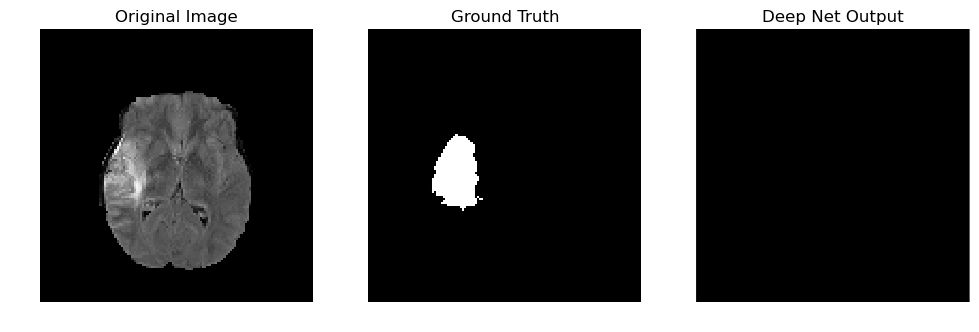

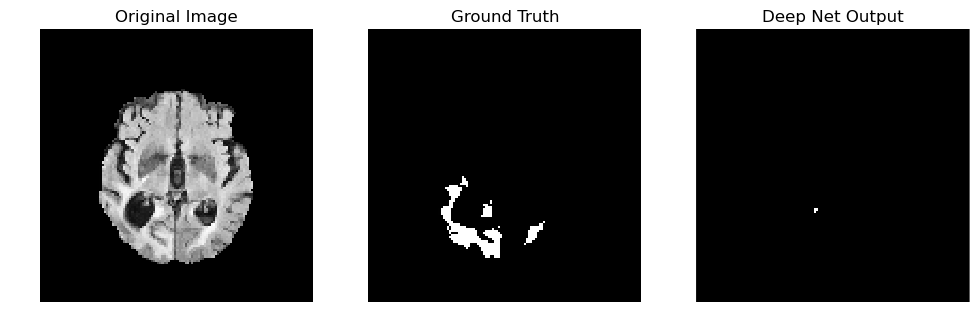

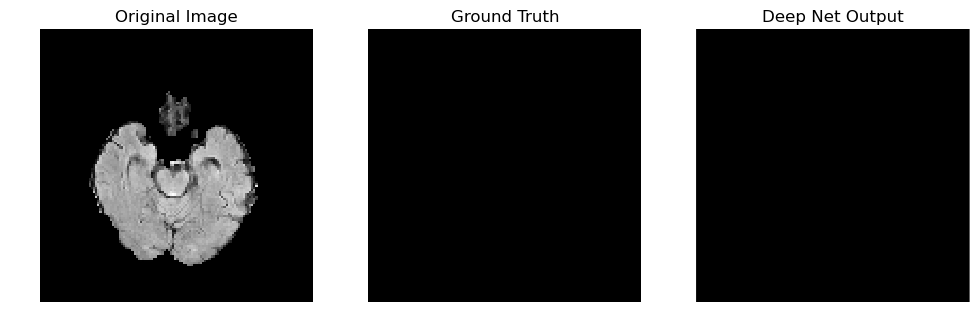

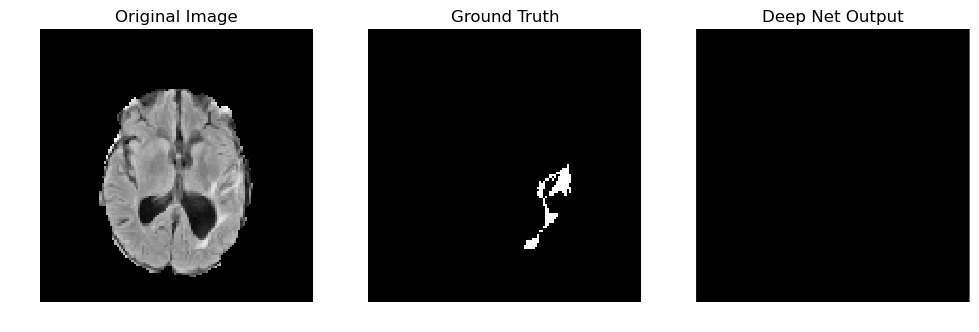

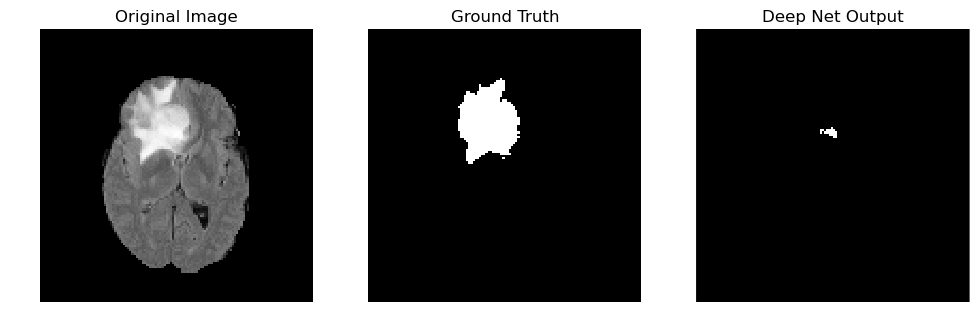

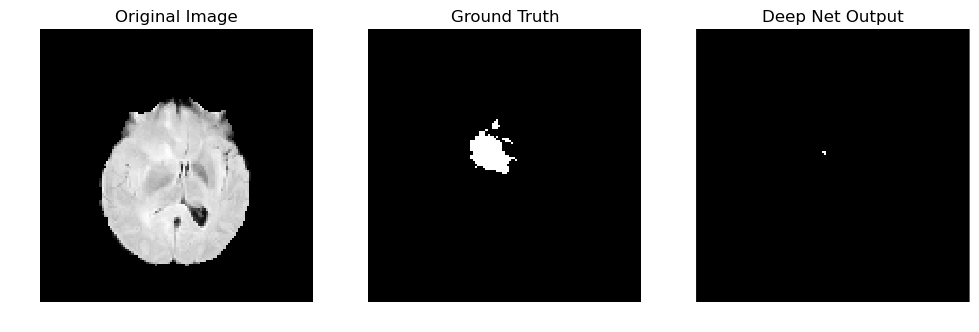

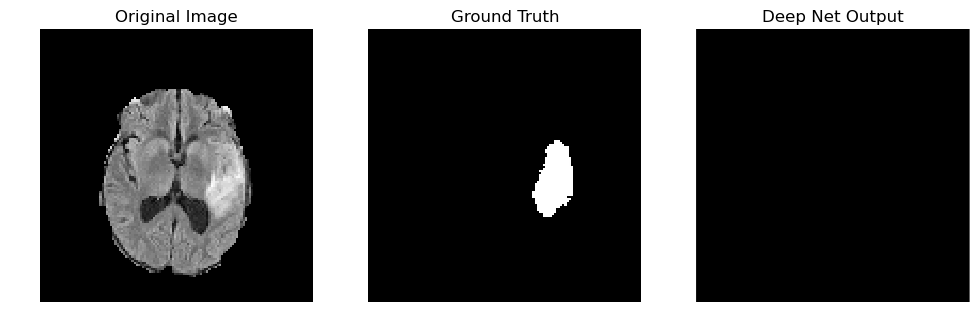

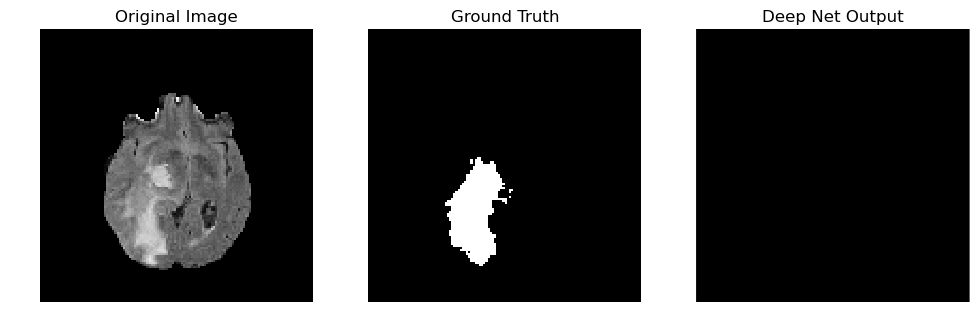

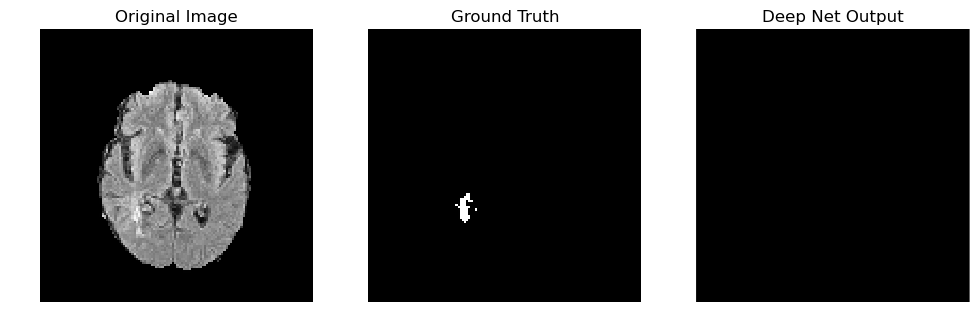

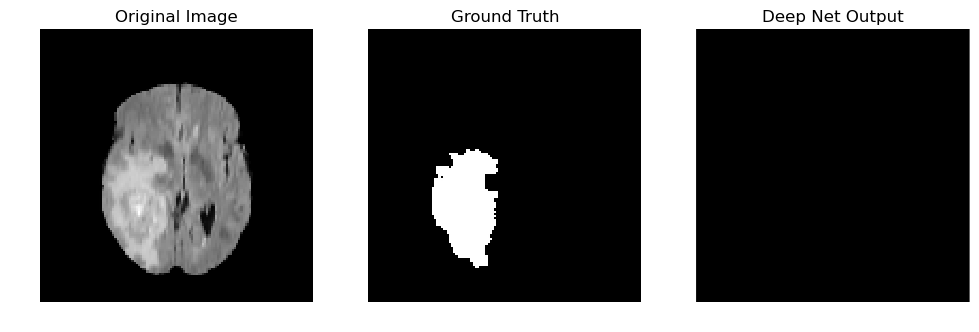

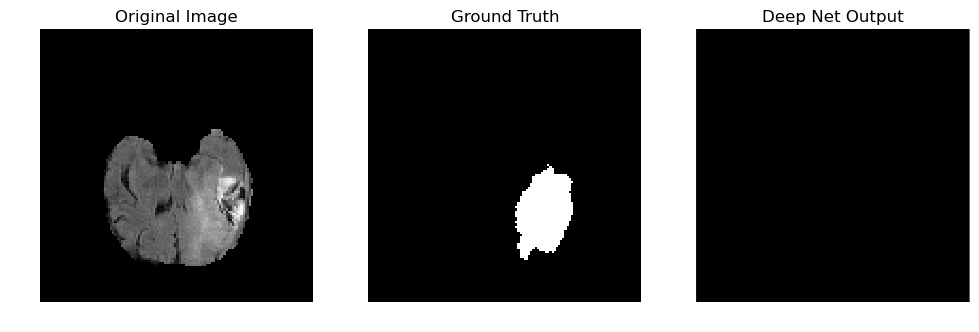

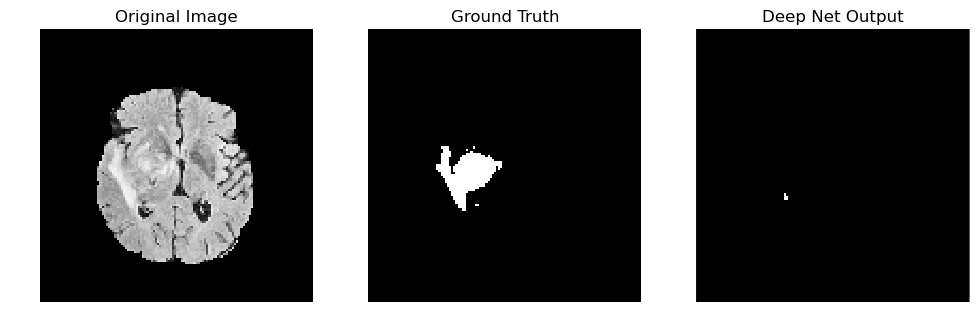

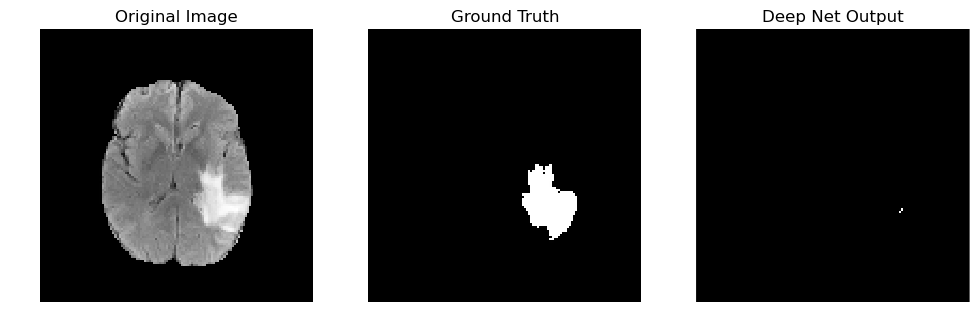

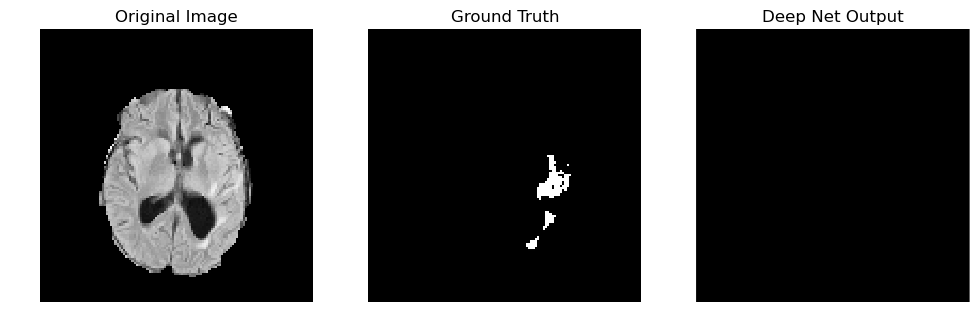

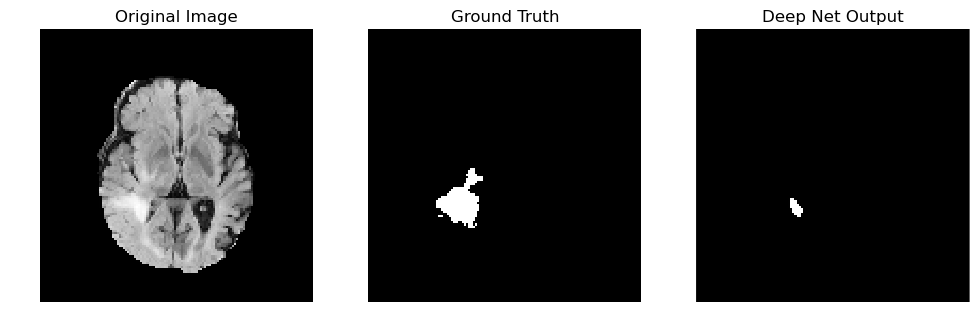

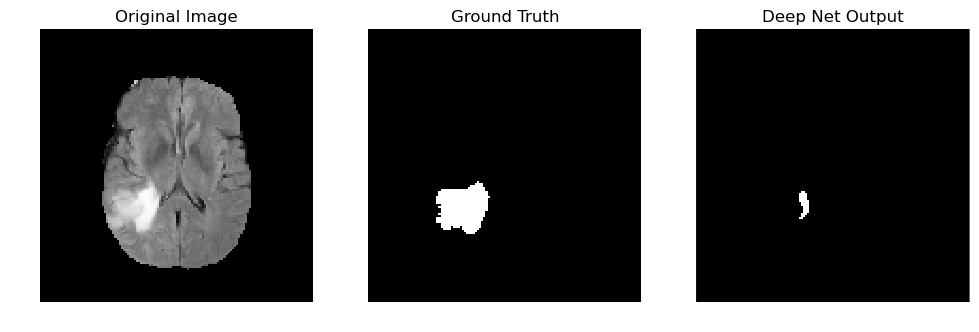

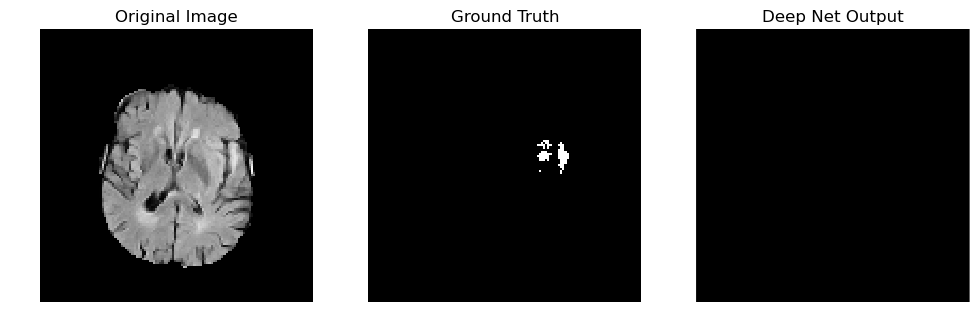

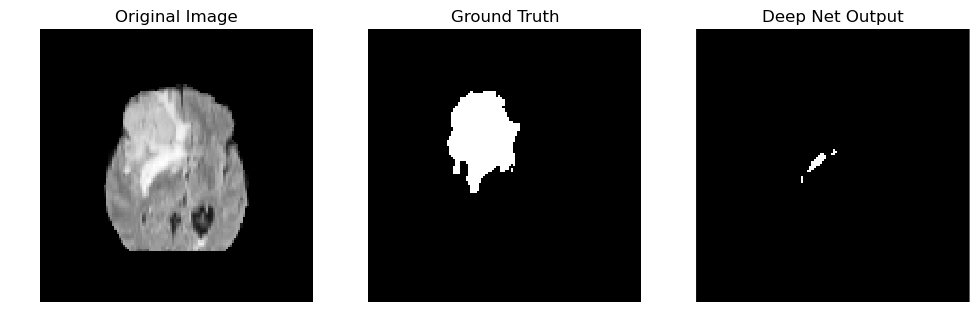

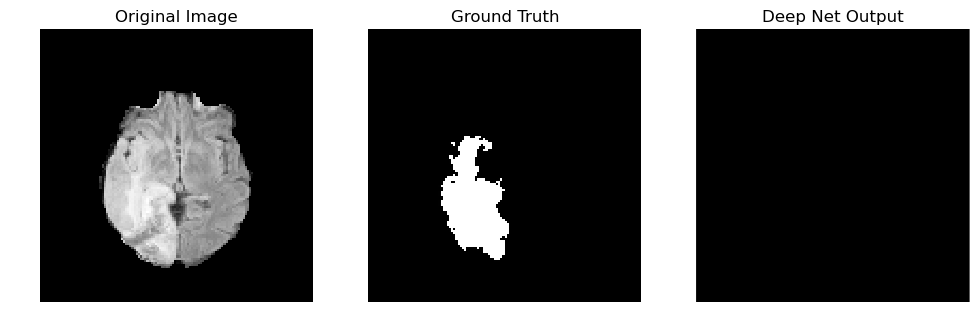

In [7]:

for i in range (0,19):
    data = np.zeros((1, 1, 128, PATCH_SIZE, PATCH_SIZE),dtype=np.float32)
    for j in range(0,128):
        data[0][0][j] = data_valid[i][0][j]

    res = get_segmentation(data)
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 3, 1)
    ax.set_title("Original Image")
    ax.imshow(data[0][0][50], cmap = cm.Greys_r, interpolation='none')
    ax.axis('off')
    ax = plt.subplot(1, 3, 2)
    ax.set_title("Ground Truth")
    ax.imshow(target_valid[i][0][50], cmap = cm.Greys_r, interpolation='none')
    ax.axis('off')
    ax = plt.subplot(1, 3, 3)
    ax.set_title("Deep Net Output")
    ax.imshow(res.argmax(1)[0][50], cmap = cm.Greys_r, interpolation='none')            
    ax.axis('off')

